## Do all necessary imports and client setup 
###### -- use it to setup the python environment and install all packages using requirement.txt

In [1]:
# pip install weaviate-client
# pip install -Uqq langchain-weaviate
# pip install jq
# pip install langgraph

In [ ]:
import os
from typing import List, Tuple
from langchain_openai import AzureOpenAIEmbeddings
from langchain_openai import AzureChatOpenAI
from langgraph.graph import StateGraph, END, START

os.environ["MODEL"] = "gpt-4o-mini"
os.environ["EMB_MODEL"] = "text-embedding-3-small"

llm_call = AzureChatOpenAI(api_key= os.getenv("AZURE_OPENAI_API_KEY"),
        azure_endpoint= os.getenv("AZURE_OPENAI_ENDPOINT"),
        api_version=os.getenv("OPENAI_API_VERSION"),
        model=os.getenv("MODEL"),
        )

emd_call = AzureOpenAIEmbeddings(api_key= os.getenv("AZURE_OPENAI_API_KEY"),
                                 azure_endpoint= os.getenv("AZURE_OPENAI_ENDPOINT"),
                                 api_version=os.getenv("OPENAI_API_VERSION"),
                                 model=os.getenv("EMB_MODEL"),)

In [ ]:
import weaviate
from weaviate.classes.init import Auth
# Best practice: store your credentials in environment variables

client = weaviate.connect_to_weaviate_cloud(
    cluster_url=os.getenv("weaviate_url"),  # Replace with your Weaviate Cloud URL
    auth_credentials=Auth.api_key(os.getenv("weaviate_api_key")),  # Replace with your Weaviate Cloud key
)
# client.close()


## load the self_critique_loop_dataset to vector store

In [5]:
from langchain_community.document_loaders.json_loader import JSONLoader

doc_path = "self_critique_loop_dataset.json"
# Step 2: Load the JSON data into LangChain documents
# Define the metadata extraction function.
def metadata_func(record: dict, metadata: dict) -> dict:
    metadata["doc_id"] = record.get("doc_id"),
    metadata["source"] = record.get("source"),
    metadata["question"] = record.get("question"),
    metadata["last_updated"] = record.get("last_updated"),

    return metadata
loader = JSONLoader(doc_path,
                    jq_schema=".[]",
                    content_key = "answer_snippet",
                    metadata_func= metadata_func,
                    )   
documents = loader.load()


In [6]:
# Extract all page_content values
page_contents = [doc.page_content for doc in documents]
# page_contents

In [7]:
metadata = [doc.metadata for doc in documents]
# metadata

In [8]:
# FOr all document, checking the average characters count
sum(len(pg) for pg in page_contents)/len(page_contents)

79.3

## Create vector store


In [9]:
from langchain_weaviate.vectorstores import WeaviateVectorStore
db = WeaviateVectorStore.from_documents(documents, emd_call, client=client)


In [10]:
len(documents)

30

## Create Langgraph

### Define State

In [42]:
from typing import TypedDict, List, Dict, Annotated
class ragState(TypedDict):
    user_question: Annotated[str, "the question asked by user"]
    top_k: Annotated[int, "top k answers to be retrieved from vectorstore"]
    kb_hits: Annotated[List[Dict], "list of retrieved knowledge base hits"]
    initial_answer: Annotated[str, "the initial answer to the user question based on retrieved knowledge base hits generated by LLM"]
    critique_comment: Annotated[str, "the critique result of the initial answer generated by LLM"]
    refined_answer: Annotated[str, "the refined answer to the user question based on the critique result generated by LLM"]
    answer: Annotated[str, "the final answer to the user question"]

### Define retrieve_kb node

In [43]:
# add modes

def retrieve_kb(state:ragState)->List[Dict]:
    retriever = db.as_retriever(search_type="similarity", search_kwargs={"k": state["top_k"]})
    ret_docs = retriever.invoke(state["user_question"])
    kb_hits = [{"doc_id":doc.metadata["doc_id"],"answer_snippet":doc.page_content, "source":doc.metadata["source"]} for doc in ret_docs]
    print("kb_hits retrieved are : ",kb_hits)
    return {"kb_hits":kb_hits}

### Define generate_answer node

In [44]:
from langchain_core.prompts import ChatPromptTemplate
def generate_answer(state: ragState) -> str:
    context_prep = [(i["doc_id"] , i["answer_snippet"]) for i in state["kb_hits"]]
    message = ChatPromptTemplate.from_messages([
        ('system', """You are a software best-practices assistant.
User Question:
{user_question}

Retrieved Snippets:
{context}

Task:
Based on these snippets, write a concise answer to the user’s question.
Cite each snippet you use by its doc_id in square brackets (e.g., [KB004]).
Return only the answer text.
         """),
        ('user', "{user_question}"),]
         ).invoke({"user_question": state["user_question"],
                    "context": context_prep},config={"temperature": 0.0})
    
    response = llm_call.invoke(message)
    print("initial_answer generated is : ",response.content)
    return {"initial_answer":response.content}

### Define critique_answer node

In [45]:
def critique_answer(state: ragState) -> str:
    context_prep = [(i["doc_id"] , i["answer_snippet"]) for i in state["kb_hits"]]
    message = ChatPromptTemplate.from_messages([
        ('system', """You are a critical QA assistant. The user asked: {user_question}

Initial Answer:
{initial_answer}

KB Snippets:
{context}

Task:
Determine if the initial answer fully addresses the question using only these snippets.
- If it does, respond exactly: COMPLETE
- If it misses any point or cites missing info, respond: REFINE: <short list of missing topic keywords>

Return exactly one line.
         """),
        ('user', "{user_question}"),]
         ).invoke({"user_question": state["user_question"],
                   "initial_answer": state["initial_answer"],
                    "context": context_prep},config={"temperature": 0.0})
    
    response = llm_call.invoke(message)
    print("critique_comment is : ",response.content)
    return {"critique_comment":response.content}

### Define refine_answer node

In [46]:
def refine_answer(state: ragState) -> str:
    additional_kb_hits= retrieve_kb({"user_question": f"{state['user_question']} and information on {state['critique_comment']}",
                                       "top_k": 1})["kb_hits"]
    print(additional_kb_hits)
    additional_context_prep = [(i["doc_id"] , i["answer_snippet"]) for i in additional_kb_hits]
    message = ChatPromptTemplate.from_messages([
        ('system', """You are a software best-practices assistant refining your answer. 
         The user asked: {user_question}

Initial Answer:
{initial_answer}

Critique: {critique_comment}

Additional Snippet:
{additional_context_prep}

Task:
Incorporate this snippet into the answer, covering the missing points.
Cite any snippet you use by doc_id in square brackets.
Return only the final refined answer.
         """),
        ('user', "{user_question}"),]
         ).invoke({"user_question": state["user_question"],
                   "initial_answer": state["initial_answer"],
                    "critique_comment": state["critique_comment"],
                    "additional_context_prep":additional_context_prep},config={"temperature": 0.0})
    
    response = llm_call.invoke(message,)
    print("refined answer is : ",response.content)
    return {"refined_answer":response.content}

### Define json_response node

In [47]:
def json_response(state: ragState) -> str:
    if state.get("critique_comment", "").strip().upper() == "COMPLETE":
        return {"answer":state["initial_answer"]}
    elif state.get("critique_comment","").strip().upper().startswith("REFINE:"):
        return {"answer":state["refined_answer"]}

### Define decision_route

In [48]:
def decision_route(state: ragState) -> str:
    if state.get("critique_comment", "").strip().upper() == "COMPLETE":
        return "finalize_answer"
    elif state.get("critique_comment","").strip().upper().startswith("REFINE:"):
        return "refine"
    # if state["critique_comment"] == "COMPLETE":
    #     return "finalize_answer"
    # elif state["critique_comment"].startswith("REFINE:"):
    #     return "refine"
    else:
        raise ValueError(f"Unexpected critique_comment: {state["critique_comment"]}")

### Build Graph

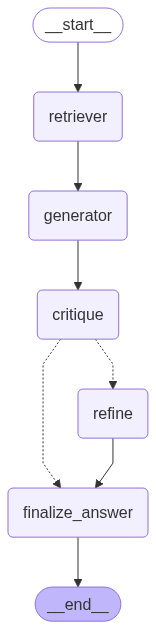

In [49]:

builder = StateGraph(ragState)
builder.add_node("retriever",retrieve_kb)
builder.add_node("generator",generate_answer)
builder.add_node("critique", critique_answer)
builder.add_node("refine", refine_answer)
builder.add_node("finalize_answer", json_response)


builder.add_edge(START,"retriever")
builder.add_edge("retriever","generator")
builder.add_edge("generator","critique")
builder.add_conditional_edges("critique",decision_route
                              ,{"finalize_answer": "finalize_answer","refine": "refine"})
builder.add_edge("refine", "finalize_answer")
builder.add_edge("finalize_answer", END)
raggraph = builder.compile()
raggraph

## Test report

In [54]:
Q1 = "What are best practices for caching?"
response = raggraph.invoke({"user_question": Q1,
                            "top_k": 5,})
print("\n------------- Final Response -------------\n")
print(response["answer"])

kb_hits retrieved are :  [{'doc_id': ['KB013'], 'answer_snippet': "When addressing caching, it's important to follow well-defined patterns...", 'source': ['caching_guide.md']}, {'doc_id': ['KB003'], 'answer_snippet': "When addressing caching, it's important to follow well-defined patterns...", 'source': ['caching_guide.md']}, {'doc_id': ['KB023'], 'answer_snippet': "When addressing caching, it's important to follow well-defined patterns...", 'source': ['caching_guide.md']}, {'doc_id': ['KB022'], 'answer_snippet': "When addressing performance tuning, it's important to follow well-defined patterns...", 'source': ['performance tuning_guide.md']}, {'doc_id': ['KB002'], 'answer_snippet': "When addressing performance tuning, it's important to follow well-defined patterns...", 'source': ['performance tuning_guide.md']}]
initial_answer generated is :  When addressing caching, it's important to follow well-defined patterns. This includes strategies such as:

1. **Specify Cache Expiration**: Def

In [55]:
Q2 = "How should I set up CI/CD pipelines?"
response = raggraph.invoke({"user_question": Q2,
                            "top_k": 5,})
print("\n------------- Final Response -------------\n")
print(response["answer"])

kb_hits retrieved are :  [{'doc_id': ['KB027'], 'answer_snippet': "When addressing CI/CD, it's important to follow well-defined patterns...", 'source': ['CI/CD_guide.md']}, {'doc_id': ['KB007'], 'answer_snippet': "When addressing CI/CD, it's important to follow well-defined patterns...", 'source': ['CI/CD_guide.md']}, {'doc_id': ['KB017'], 'answer_snippet': "When addressing CI/CD, it's important to follow well-defined patterns...", 'source': ['CI/CD_guide.md']}, {'doc_id': ['KB006'], 'answer_snippet': "When addressing unit testing, it's important to follow well-defined patterns...", 'source': ['unit testing_guide.md']}, {'doc_id': ['KB026'], 'answer_snippet': "When addressing unit testing, it's important to follow well-defined patterns...", 'source': ['unit testing_guide.md']}]
initial_answer generated is :  When setting up CI/CD pipelines, it's important to follow well-defined patterns to ensure efficiency and reliability throughout the software development lifecycle. This includes au

In [58]:
Q3 = "What are performance tuning tips?"
response = raggraph.invoke({"user_question": Q3,
                            "top_k": 5,})
print("\n------------- Final Response -------------\n")
print(response["answer"])

kb_hits retrieved are :  [{'doc_id': ['KB022'], 'answer_snippet': "When addressing performance tuning, it's important to follow well-defined patterns...", 'source': ['performance tuning_guide.md']}, {'doc_id': ['KB002'], 'answer_snippet': "When addressing performance tuning, it's important to follow well-defined patterns...", 'source': ['performance tuning_guide.md']}, {'doc_id': ['KB012'], 'answer_snippet': "When addressing performance tuning, it's important to follow well-defined patterns...", 'source': ['performance tuning_guide.md']}, {'doc_id': ['KB013'], 'answer_snippet': "When addressing caching, it's important to follow well-defined patterns...", 'source': ['caching_guide.md']}, {'doc_id': ['KB003'], 'answer_snippet': "When addressing caching, it's important to follow well-defined patterns...", 'source': ['caching_guide.md']}]
initial_answer generated is :  When addressing performance tuning, it's important to follow well-defined patterns to ensure effective optimization. Key a

In [57]:
Q4 = "How do I version my APIs?"
response = raggraph.invoke({"user_question": Q4,
                            "top_k": 5,})
print("\n------------- Final Response -------------\n")
print(response["answer"])

kb_hits retrieved are :  [{'doc_id': ['KB015'], 'answer_snippet': "When addressing API versioning, it's important to follow well-defined patterns...", 'source': ['API versioning_guide.md']}, {'doc_id': ['KB005'], 'answer_snippet': "When addressing API versioning, it's important to follow well-defined patterns...", 'source': ['API versioning_guide.md']}, {'doc_id': ['KB025'], 'answer_snippet': "When addressing API versioning, it's important to follow well-defined patterns...", 'source': ['API versioning_guide.md']}, {'doc_id': ['KB027'], 'answer_snippet': "When addressing CI/CD, it's important to follow well-defined patterns...", 'source': ['CI/CD_guide.md']}, {'doc_id': ['KB007'], 'answer_snippet': "When addressing CI/CD, it's important to follow well-defined patterns...", 'source': ['CI/CD_guide.md']}]
initial_answer generated is :  When versioning your APIs, it's crucial to follow well-defined patterns to ensure clarity and usability. You can consider methods such as including the ve

In [56]:
Q5 = "What should I consider for error handling?"
response = raggraph.invoke({"user_question": Q5,
                            "top_k": 5,})
print("\n------------- Final Response -------------\n")
print(response["answer"])

kb_hits retrieved are :  [{'doc_id': ['KB029'], 'answer_snippet': "When addressing error handling, it's important to follow well-defined patterns...", 'source': ['error handling_guide.md']}, {'doc_id': ['KB009'], 'answer_snippet': "When addressing error handling, it's important to follow well-defined patterns...", 'source': ['error handling_guide.md']}, {'doc_id': ['KB019'], 'answer_snippet': "When addressing error handling, it's important to follow well-defined patterns...", 'source': ['error handling_guide.md']}, {'doc_id': ['KB001'], 'answer_snippet': "When addressing debugging, it's important to follow well-defined patterns...", 'source': ['debugging_guide.md']}, {'doc_id': ['KB011'], 'answer_snippet': "When addressing debugging, it's important to follow well-defined patterns...", 'source': ['debugging_guide.md']}]
initial_answer generated is :  When addressing error handling, it's important to follow well-defined patterns to ensure that errors are managed effectively. This include